<a href="https://colab.research.google.com/github/JaseemKV/jaseemkv/blob/main/Sentiment_Analysis_on_IMDB_Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T092759Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D081cc0e669a6f968eb20c1d302ee801e13ea3136a9b2bb6c1acfe841ce475833fc24f0567636ab5ca7666df6581127474ba1009c3572acecd16c073562d1b24dbd6c2edb2c7ef5611fa9536c681f31061ca6267fdff450f5db05a47c09322c9f91f5269aa228ff6a3318d77381bfbf8910c812b584225da67930127d504f133eff7106b68f3cf9160c7e26025b298a9d902b695d3d39cf4d4b83891220bc8d55946641b8e5c9bb42415f2a19b591a7ff9ac36190ad2f4f931e25a5bb8e1ae85739ca85f8cedafb7069352e006e84afcc5748d5d50bd54010e0b9f9ea8d5328668900ea5ef9a70b6323e6d20c5c11c0048d91aaef1df867ce082973028e923902'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.


![](https://github.com/Shubham-Trivedi/Sentiment-Analysis-on-IMDB-dataset/blob/main/imdb%20logo1.jpg?raw=true)

# Sentiment analysis on Reviews given by viewers on IMDB



# The Dataset and The Problem to Solve


>In this notebbok, we’ll use an IMDB dataset of 50k movie reviews available on Kaggle. The dataset contains 2 columns (review and sentiment) that will help us identify whether a review is positive or negative.
>
>*Problem formulation: Our goal is to find which machine learning model is best suited to predict sentiment (output) given a movie review (input).*


# 1. Importing necessary libraries


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [13]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv



# 2. Preparing the data

In [17]:
df_review = pd.read_csv("/content/IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


This dataset contains 50000 rows; however, to train our model faster in the following steps, we’re going to take a smaller sample of 10000 rows. This small sample will contain 9000 positive and 1000 negative reviews to make the data imbalanced (so I can teach you undersampling and oversampling techniques in the next step)

In [18]:
df_positive = df_review[df_review['sentiment']=='positive'][:9000]
df_negative = df_review[df_review['sentiment']=='negative'][:1000]

df_review_imb = pd.concat([df_positive,df_negative ])

## Dealing with Imbalanced Classes

In most cases, you’ll have a large amount of data for one class, and much fewer observations for other classes. This is known as imbalanced data because the number of observations per class is not equally distributed.

Let’s take a look at how our df_review_imb dataset is distributed.

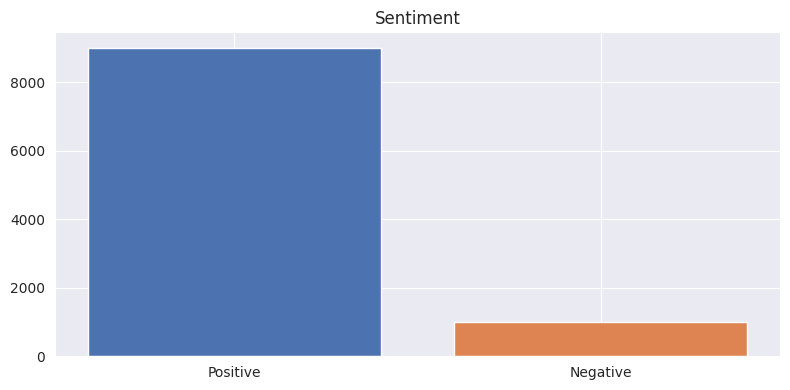

In [19]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

To resample our data we use the imblearn library. You can either undersample positive reviews or oversample negative reviews (you need to choose based on the data you’re working with). In this case, we’ll use the RandomUnderSampler

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],df_review_imb['sentiment'])


df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


We can compare the imbalanced and balanced dataset with the following code.

In [21]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
dtype: int64
sentiment
negative    1000
positive    1000
dtype: int64



## Splitting data into train and test set


In [22]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_review_bal,test_size =0.33,random_state=42)

In [23]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [24]:
train_y.value_counts()

negative    675
positive    665
Name: sentiment, dtype: int64


# 3.Text Representation (Bag of words)


Classifiers and learning algorithms expect numerical feature vectors rather than raw text documents. This is why we need to turn our movie review text into numerical vectors.

we’ll use bag of words (BOW) since we care about the frequency of the words in text reviews; however, the order of words is irrelevant. Two common ways to represent bag of words are CountVectorizer and Term Frequency, Inverse Document Frequency (TF-IDF)

we want to identify unique/representative words for positive reviews and negative reviews, so we’ll choose the TF-IDF. To turn text data into numerical vectors with TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)


Finally, let's also transform the test_x_vector, so we can test the accuracy of the model later

In [43]:
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                index=train_x.index,
                                columns=tfidf.get_feature_names_out())

,00,000,007,01pm,02,04,08,10,100,1000,...,zooming,zooms,zues,zzzzzzzzzzzzzzzzzz,æon,élan,émigré,ísnt,ïn,ünfaithful
81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
380,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4.Model Selection

In our example, our input (review) and output (sentiment) are clearly identified, so we can say we have labeled input and output data; therefore, we’re dealing with supervised learning.

We will benchmark the four classification models.



##  Support Vector Machine(SVM)


In [44]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

In [45]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all I gave this movie away'])))

['positive']
['positive']
['negative']



## Decision Tree


In [46]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

DecisionTreeClassifier()


## Naive Bayes


In [47]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()


## Logistic Regression


In [48]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(train_x_vector,train_y)

LogisticRegression()

>Note: Here notice that we are using review dataframe in vectorized form and sentiment dataframe in normal form it is so that model evaluates the vectorized values of review dataframe and gives out output in normal english not in a vectorized form so that it can be readable to us


# 5. Model Evaluation


## Mean Accuracy

In [49]:
print(svc.score(test_x_vector, test_y))
print(dec_tree.score(test_x_vector, test_y))
print(gnb.score(test_x_vector.toarray(), test_y))
print(log_reg.score(test_x_vector, test_y))

0.8136363636363636
0.6590909090909091
0.6409090909090909
0.8318181818181818


SVM and Logistic Regression perform better than the other two classifiers, with SVM having a slight advantage (84% of accuracy).Thus,we’ll focus only on SVM.

## F1 Score

F1 Score is the weighted average of Precision and Recall. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. Also, F1 takes into account how the data is distributed, so it’s useful when you have data with imbalance classes.

In [50]:
from sklearn.metrics import f1_score

f1_score(test_y,svc.predict(test_x_vector),
          labels = ['positive','negative'],average=None)

array([0.81669151, 0.81047766])

## Classification report

In [51]:
from sklearn.metrics import classification_report

print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.82      0.82      0.82       335
    negative       0.81      0.81      0.81       325

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660



## Confusion Matrix

A confusion matrix is a table that allows visualization of the performance of an algorithm. This table typically has two rows and two columns that report the number of false positives, false negatives, true positives, and true negatives

In [52]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y,
                           svc.predict(test_x_vector),
                           labels = ['positive', 'negative'])
conf_mat

array([[274,  61],
       [ 62, 263]])


# 6. Tuning the Model


## GridSearchCV

This is technique consists of an exhaustive search on specified parameters in order to obtain the optimum values of hyperparameters.

In [53]:
from sklearn.model_selection import GridSearchCV
#set the parameters
params = {'C': [1,4,8,16,32], 'kernel' : ['linear','rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,params, cv = 5)
svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

In [54]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')


So Above obtained paramters and kernel are the best for our model to obtain desired results as accurate as possible